In [ ]:
# Install Kaggle API
!pip install kaggle

# Upload the kaggle.json file
from google.colab import files
files.upload()

# Make a directory for the Kaggle configuration file and move it there
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset (replace 'gpreda/titanic' with your desired dataset path)
!kaggle datasets download -d abhishek/siim-dicom-images
# Unzip the downloaded dataset
!unzip siim-dicom-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: siim-original/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2136.1517875171.310189/1.2.276.0.7230010.3.1.3.8323329.2136.1517875171.310188/1.2.276.0.7230010.3.1.4.8323329.2136.1517875171.310190.dcm  
  inflating: siim-original/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2137.1517875171.310659/1.2.276.0.7230010.3.1.3.8323329.2137.1517875171.310658/1.2.276.0.7230010.3.1.4.8323329.2137.1517875171.310660.dcm  
  inflating: siim-original/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2138.1517875171.323419/1.2.276.0.7230010.3.1.3.8323329.2138.1517875171.323418/1.2.276.0.7230010.3.1.4.8323329.2138.1517875171.323420.dcm  
  inflating: siim-original/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.2139.1517875171.325963/1.2.276.0.7230010.3.1.3.8323329.2139.1517875171.325962/1.2.276.0.7230010.3.1.4.8323329.2139.1517875171.325964.dcm  
  inflating: siim-original/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.214

In [ ]:
!pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00


In [ ]:
from __future__ import print_function

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno

import collections
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import pydicom
from glob import glob

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)


def all_gather(data):
    """
    Run all_gather on arbitrary picklable data (not necessarily tensors)
    Args:
        data: any picklable object
    Returns:
        list[data]: list of data gathered from each rank
    """
    world_size = get_world_size()
    if world_size == 1:
        return [data]

    # serialized to a Tensor
    buffer = pickle.dumps(data)
    storage = torch.ByteStorage.from_buffer(buffer)
    tensor = torch.ByteTensor(storage).to("cuda")

    # obtain Tensor size of each rank
    local_size = torch.tensor([tensor.numel()], device="cuda")
    size_list = [torch.tensor([0], device="cuda") for _ in range(world_size)]
    dist.all_gather(size_list, local_size)
    size_list = [int(size.item()) for size in size_list]
    max_size = max(size_list)

    # receiving Tensor from all ranks
    # we pad the tensor because torch all_gather does not support
    # gathering tensors of different shapes
    tensor_list = []
    for _ in size_list:
        tensor_list.append(torch.empty((max_size,), dtype=torch.uint8, device="cuda"))
    if local_size != max_size:
        padding = torch.empty(size=(max_size - local_size,), dtype=torch.uint8, device="cuda")
        tensor = torch.cat((tensor, padding), dim=0)
    dist.all_gather(tensor_list, tensor)

    data_list = []
    for size, tensor in zip(size_list, tensor_list):
        buffer = tensor.cpu().numpy().tobytes()[:size]
        data_list.append(pickle.loads(buffer))

    return data_list


def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.no_grad():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        log_msg = self.delimiter.join([
            header,
            '[{0' + space_fmt + '}/{1}]',
            'eta: {eta}',
            '{meters}',
            'time: {time}',
            'data: {data}',
            'max mem: {memory:.0f}'
        ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                print(log_msg.format(
                    i, len(iterable), eta=eta_string,
                    meters=str(self),
                    time=str(iter_time), data=str(data_time),
                    memory=torch.cuda.max_memory_allocated() / MB))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {} ({:.4f} s / it)'.format(
            header, total_time_str, total_time / len(iterable)))


def collate_fn(batch):
    return tuple(zip(*batch))


def warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor):

    def f(x):
        if x >= warmup_iters:
            return 1
        alpha = float(x) / warmup_iters
        return warmup_factor * (1 - alpha) + alpha

    return torch.optim.lr_scheduler.LambdaLR(optimizer, f)


def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


def setup_for_distributed(is_master):
    """
    This function disables printing when not in master process
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        force = kwargs.pop('force', False)
        if is_master or force:
            builtin_print(*args, **kwargs)

    __builtin__.print = print


def is_dist_avail_and_initialized():
    if not dist.is_available():
        return False
    if not dist.is_initialized():
        return False
    return True


def get_world_size():
    if not is_dist_avail_and_initialized():
        return 1
    return dist.get_world_size()


def get_rank():
    if not is_dist_avail_and_initialized():
        return 0
    return dist.get_rank()


def is_main_process():
    return get_rank() == 0


def save_on_master(*args, **kwargs):
    if is_main_process():
        torch.save(*args, **kwargs)


def init_distributed_mode(args):
    if 'RANK' in os.environ and 'WORLD_SIZE' in os.environ:
        args.rank = int(os.environ["RANK"])
        args.world_size = int(os.environ['WORLD_SIZE'])
        args.gpu = int(os.environ['LOCAL_RANK'])
    elif 'SLURM_PROCID' in os.environ:
        args.rank = int(os.environ['SLURM_PROCID'])
        args.gpu = args.rank % torch.cuda.device_count()
    else:
        print('Not using distributed mode')
        args.distributed = False
        return

    args.distributed = True

    torch.cuda.set_device(args.gpu)
    args.dist_backend = 'nccl'
    print('| distributed init (rank {}): {}'.format(
        args.rank, args.dist_url), flush=True)
    torch.distributed.init_process_group(backend=args.dist_backend, init_method=args.dist_url,
                                         world_size=args.world_size, rank=args.rank)
    torch.distributed.barrier()
    setup_for_distributed(args.rank == 0)

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [ ]:
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 1
        current_position += lengths[index]

    return mask.reshape(width, height)

In [ ]:
class SIIMDataset(torch.utils.data.Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.height = 256
        self.width = 256
        self.image_dir = img_dir
        self.image_info = collections.defaultdict(dict)

        self.df = self.df.drop_duplicates('ImageId', keep='last').reset_index(drop=True)

        counter = 0
        for index, row in tqdm(self.df.iterrows(), total=len(self.df)):
            dcm_id = row['ImageId']
            dcm_path = row['image_path']
            self.image_info[counter]["image_id"] = dcm_id
            self.image_info[counter]["image_path"] = dcm_path
            self.image_info[counter]["annotations"] = row[" EncodedPixels"].strip()
            counter += 1

    def __getitem__(self, idx):
        img_path = self.image_info[idx]["image_path"]
        img = pydicom.dcmread(img_path).pixel_array
        img = Image.fromarray(img).convert("RGB")
        width, height = img.size
        img = img.resize((self.width, self.height), resample=Image.BILINEAR)
        info = self.image_info[idx]
        if info["annotations"] != '-1':
            mask = rle2mask(info['annotations'], width, height)
            mask = Image.fromarray(mask.T)
            mask = mask.resize((self.width, self.height), resample=Image.BILINEAR)
            mask = np.expand_dims(mask, axis=0)

            pos = np.where(np.array(mask)[0, :, :])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
            labels = torch.ones((1,), dtype=torch.int64)
            masks = torch.as_tensor(mask, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.zeros((1,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd
        else:
            mask = rle2mask('1 {}'.format(width*height), width, height)
            mask = Image.fromarray(mask.T)
            mask = mask.resize((self.width, self.height), resample=Image.BILINEAR)
            mask = np.expand_dims(mask, axis=0)

            pos = np.where(np.array(mask)[0, :, :])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            boxes = torch.as_tensor([[xmin, ymin, xmax, ymax]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            masks = torch.as_tensor(mask, dtype=torch.uint8)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            iscrowd = torch.ones((1,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["masks"] = masks
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

        return transforms.ToTensor()(img), target

    def __len__(self):
        return len(self.image_info)

In [ ]:
dicom_file_paths = []
files_name = []
for folder1 in os.listdir('/content/siim-original/dicom-images-train'):
    for folder2 in os.listdir(f'/content/siim-original/dicom-images-train/{folder1}'):
        for file in os.listdir(f'/content/siim-original/dicom-images-train/{folder1}/{folder2}'):
            dicom_file_paths.append(os.path.join('/content/siim-original/dicom-images-train', folder1, folder2, file))
            files_name.append(file[:-4])
len(files_name)

10712

In [ ]:
train_path = '/content/siim-original/dicom-images-train'
rle_path = '/content/train-rle.csv'

train_filenames = os.listdir(train_path)
rle_csv = pd.read_csv(rle_path)

rle_csv = rle_csv.drop_duplicates(subset=['ImageId'])
rle_csv = rle_csv[rle_csv['ImageId'].isin(files_name)]

len(rle_csv)

10675

In [ ]:
def process_labels(df): #Converts labels to binary

    labels = df[" EncodedPixels"].to_list()
    a = []
    for i in labels:
      if i == ' -1':
        a.append(0)
      else: a.append(1)
    df["Class"] = np.array(a, dtype='uint8')
    return df

def add_full_path(df, train_path):
    my_glob = glob(train_path + '/*/*/*.dcm')

    full_img_paths = {os.path.basename(x).split('.dcm')[0]: x for x in my_glob}
    dataset_path = df['ImageId'].map(full_img_paths.get)

    df['image_path'] = dataset_path

    return df



In [ ]:
rle_csv = add_full_path(rle_csv, train_path)
dataset_train = SIIMDataset(rle_csv, train_path)

len(dataset_train)

100%|██████████| 10675/10675 [00:00<00:00, 18209.09it/s]


10675

In [ ]:
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=4, shuffle=True, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_classes = 2
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = True

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    train_one_epoch(model_ft, optimizer, data_loader, device, epoch, print_freq=100)
    lr_scheduler.step()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-c8de86e5fd0c>:68: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  masks = torch.as_tensor(mask, dtype=torch.uint8)
<ipython-input-18-c8de86e5fd0c>:68: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make

Epoch: [0]  [   0/2669]  eta: 4:15:31  lr: 0.000001  loss: 2.0253 (2.0253)  loss_classifier: 0.7986 (0.7986)  loss_box_reg: 0.0004 (0.0004)  loss_mask: 1.1692 (1.1692)  loss_objectness: 0.0445 (0.0445)  loss_rpn_box_reg: 0.0127 (0.0127)  time: 5.7442  data: 1.1546  max mem: 4061
Epoch: [0]  [ 100/2669]  eta: 0:40:26  lr: 0.000051  loss: 0.5868 (0.8395)  loss_classifier: 0.0368 (0.2641)  loss_box_reg: 0.0065 (0.0118)  loss_mask: 0.4565 (0.5241)  loss_objectness: 0.0252 (0.0281)  loss_rpn_box_reg: 0.0108 (0.0113)  time: 0.9573  data: 0.0237  max mem: 4229
Epoch: [0]  [ 200/2669]  eta: 0:38:51  lr: 0.000101  loss: 0.4058 (0.6002)  loss_classifier: 0.0295 (0.1488)  loss_box_reg: 0.0155 (0.0130)  loss_mask: 0.3200 (0.4001)  loss_objectness: 0.0071 (0.0277)  loss_rpn_box_reg: 0.0082 (0.0105)  time: 0.9442  data: 0.0172  max mem: 4229
Epoch: [0]  [ 300/2669]  eta: 0:37:22  lr: 0.000151  loss: 0.0180 (0.5139)  loss_classifier: 0.0054 (0.1095)  loss_box_reg: 0.0000 (0.0145)  loss_mask: 0.0000 (

KeyboardInterrupt: 

In [ ]:
torch.save(model_ft.state_dict(), 'maskrcnn_resnet50_fpn.pth')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/maskrcnn_resnet50_fpn.pth /content/drive/MyDrive

In [ ]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

def plotter(img, target):
    fig,ax = plt.subplots(1)
    ax.imshow(transforms.ToPILImage()(img))
    ax.imshow(transforms.ToPILImage()(target["masks"][0].cpu() * 255), alpha=0.5)
    rect = patches.Rectangle((target["boxes"][0][0].item(),
                             target["boxes"][0][1].item()),
                             target["boxes"][0][2].item() - target["boxes"][0][0].item(),
                             target["boxes"][0][3].item() - target["boxes"][0][1].item(),
                             linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

In [ ]:
model_ft.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

<ipython-input-18-c8de86e5fd0c>:41: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  masks = torch.as_tensor(mask, dtype=torch.uint8)
<ipython-input-18-c8de86e5fd0c>:68: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  masks = torch.as_tensor(mask, dtype=torch.uin

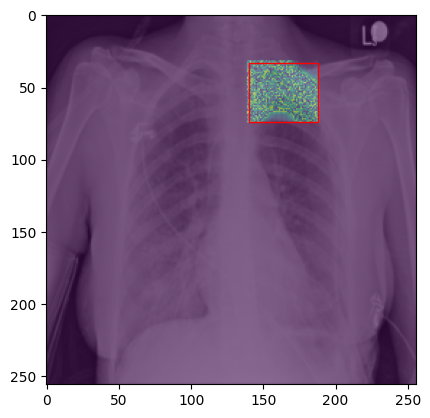

In [ ]:
for images, targets in data_loader:
  imgs = list(image.to(device) for image in images)
  mask = model_ft(imgs)
  plotter(imgs[1], mask[1])
  break


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
<ipython-input-18-c8de86e5fd0c>:68: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before convert

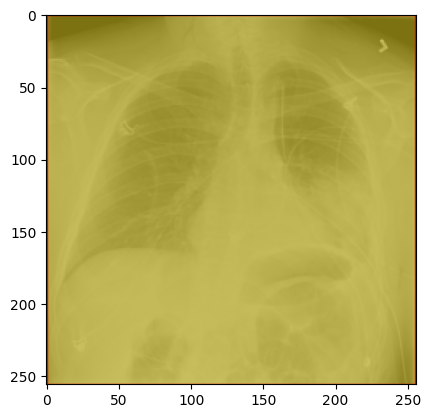

In [ ]:
for images, targets in data_loader:
  imgs = list(images)
  targets1 = list(targets)

  plotter(imgs[0], targets1[0])
  break